In [1]:
import read_data
data = read_data.read_data(300)

/home/lo/pg/ML/ML-Projekt/read_data.py:30: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


Daten liegen in dem pandas.DataFrame data. Werte in data['arr]'. Klassen in data['target']

In [2]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib.pyplot as plt

In [3]:
X = np.concatenate(data['arr'].values).reshape(-1, 256*128)
print(X.shape)
print(X)

y = data['target']
print(y.shape)
print(y)

(5700, 32768)
[[0.53835804 0.53948557 0.54231415 ... 0.62427359 0.63278792 0.63736611]
 [0.57025891 0.55897285 0.55574293 ... 0.60824552 0.61591889 0.62003003]
 [0.57360337 0.56940564 0.5652321  ... 0.69723126 0.70560226 0.71010212]
 ...
 [0.56742371 0.56886997 0.5683285  ... 0.61438716 0.62240744 0.62671828]
 [0.5511074  0.550678   0.55123278 ... 0.6270316  0.63564807 0.64028952]
 [0.58072485 0.58205473 0.58082764 ... 0.68989731 0.69810868 0.70252647]]
(5700,)
0         0
1         0
2         0
3         0
4         0
         ..
44129    18
44130    18
44131    18
44132    18
44133    18
Name: target, Length: 5700, dtype: int64


Dimensionsreduktion mit PCA
Anteil der erklärten Varianz für einige Dimensionen

In [4]:
dims = [1, 2, 3, 5, 10, 100]
X_pca = []

for dim in dims:
    pca = PCA(n_components=dim)
    transformed = pca.fit_transform(X)
    X_pca.append(transformed)
    print(f"{dim} Hauptkomponente(n): {sum(pca.explained_variance_ratio_)} variance explained")

1 Hauptkomponente(n): 0.5748846237549933 variance explained
2 Hauptkomponente(n): 0.6510424094237348 variance explained
3 Hauptkomponente(n): 0.6992218163305907 variance explained
5 Hauptkomponente(n): 0.7529995894307203 variance explained
10 Hauptkomponente(n): 0.7995596798238225 variance explained
100 Hauptkomponente(n): 0.8809320310341803 variance explained


Visualierung der transformierten Daten (2, 3 Dimensionen)

/tmp/ipykernel_13208/3744613528.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_13208/3744613528.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 19)


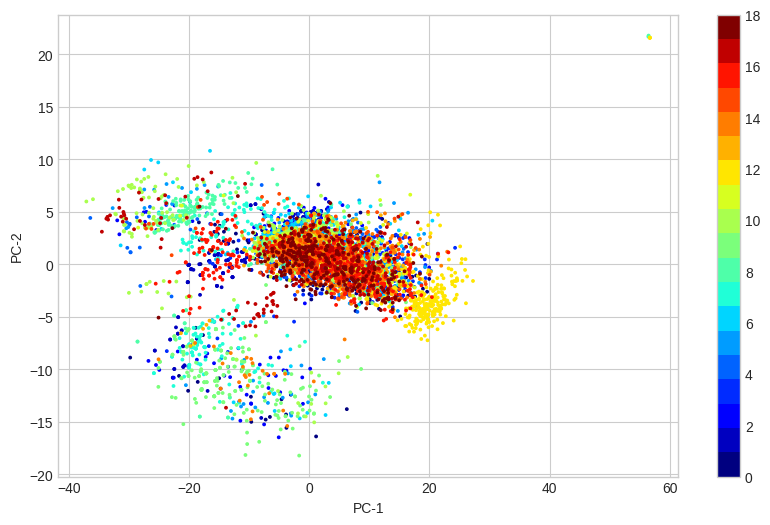

In [5]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 19)
plt.scatter(X_pca[1][:, 0], X_pca[1][:, 1], s = 3,
            cmap = c_map , c = y)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

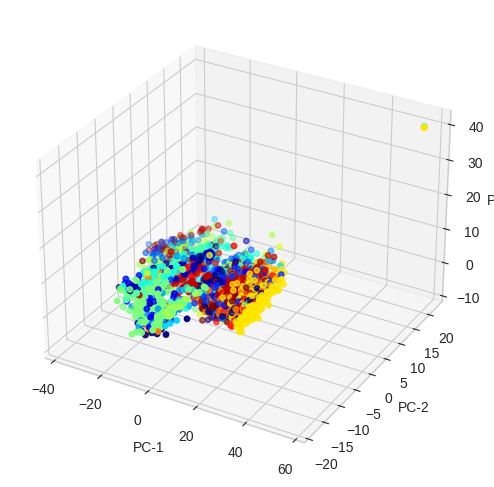

In [6]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_pca[2][:, 0], X_pca[2][:, 1], X_pca[2][:, 2], s = 15,
            cmap = c_map , c = y)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.show()

KNN mit k zwischen 1 und 100 auf den transformierten Daten
LLOCV wäre gut dauert aber lange, deshalb CV
Als Ergebnis wird der Durchschnitt der jeweiligen Scores verwendet

In [33]:
k = range(1, 101)
scores_knn = []

for i, pca_data in enumerate(X_pca):
    scores_knn.append([])
    for n_neighbors in k:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_validate(knn, pca_data, y)
        scores_knn[i].append(np.mean(scores["test_score"]))

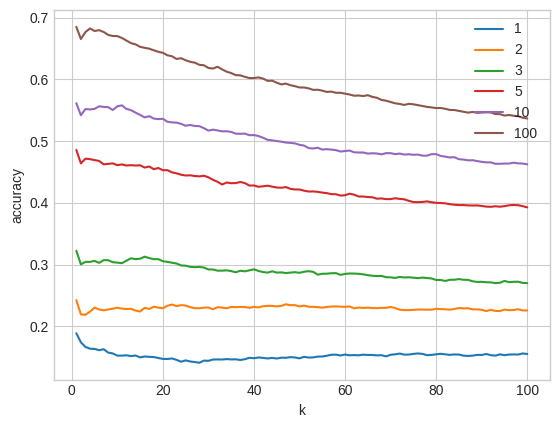

In [34]:
for elem in scores_knn:
    plt.plot(k, elem, label=dims[scores_knn.index(elem)])
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.show()

Ergebnis von KNN: Mit vielen Dimensionen noch ordentliche Ergebnisse aber im niedrig-dimensionalen Raum nicht mehr praktikabel

Klassifikation mit Entscheidungsbäumen

In [6]:
from sklearn.tree import DecisionTreeClassifier

max_depths = range(1, 11)
criterions = ["gini", "entropy", "log_loss"]

scores_tree = []

for i, pca_data in enumerate(X_pca):
    scores_tree.append([])
    for j, criterion in enumerate(criterions):
        scores_tree[i].append([])
        for max_depth in max_depths:
            tree = DecisionTreeClassifier(criterion=criterion,
                                        max_depth=max_depth)
            scores = cross_validate(tree, pca_data, y)
            scores_tree[i][j].append(np.mean(scores["test_score"]))

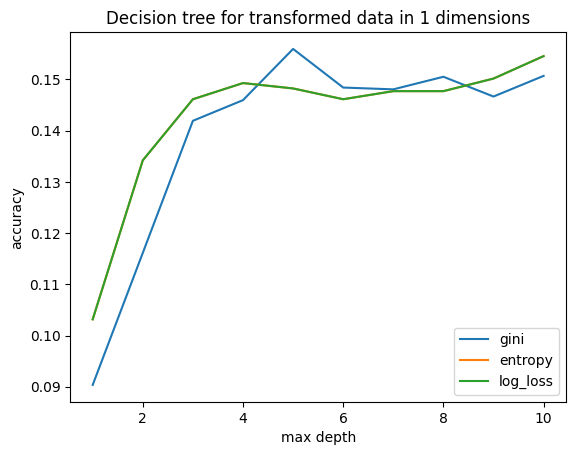

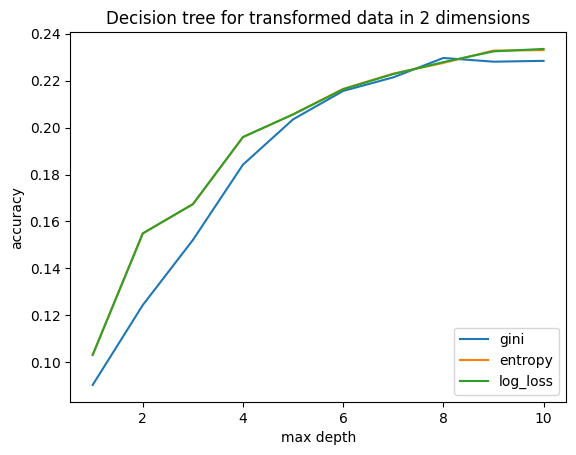

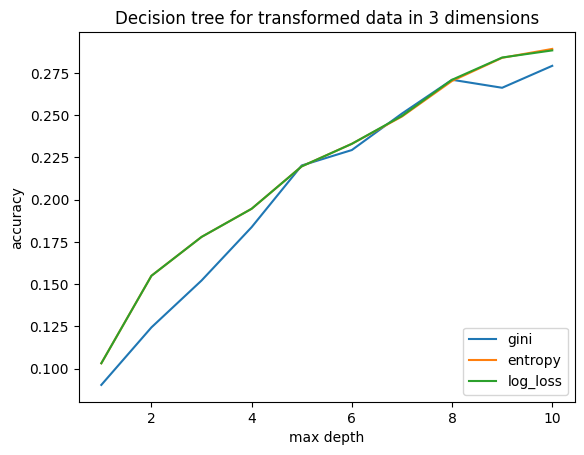

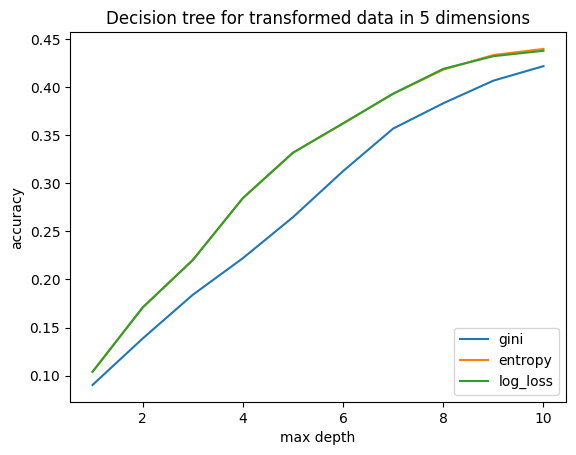

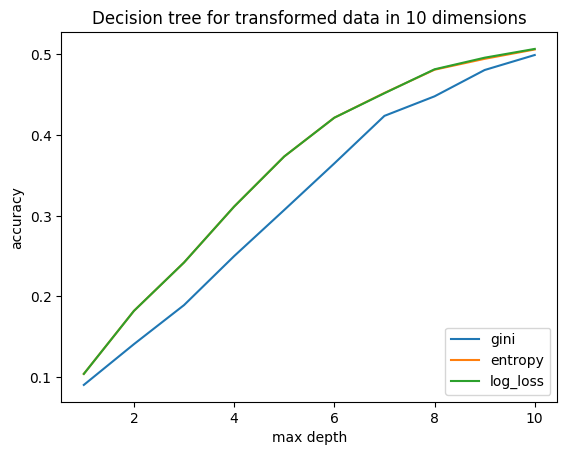

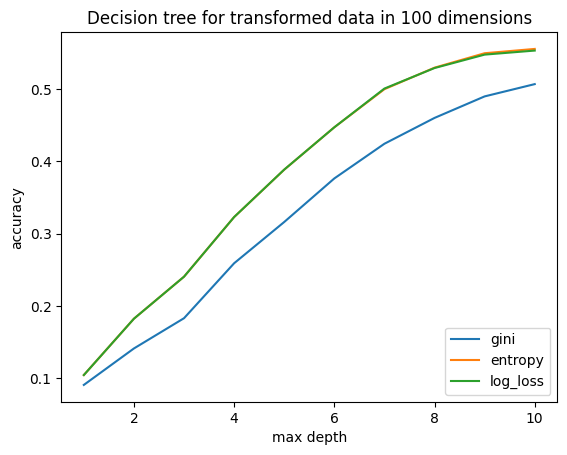

In [7]:
for elem in scores_tree: 
    for i, criterion in enumerate(elem):
        plt.plot(max_depths, elem[i], label=criterions[i])
    plt.xlabel("max depth")
    plt.ylabel("accuracy")
    plt.title(f"Decision tree for transformed data in {dims[scores_tree.index(elem)]} dimensions")
    plt.legend(loc="lower right")
    plt.show()

Die Ergebnisse sind für wenige Dimensionen erwartbar schlecht. Auf den Graphen konnten die Klassen nicht sauber linear getrennt werden

Jetzt verschiedene Ensemble-Verfahren:
1. Random Forest
2. Bagging
3. Extra Random
4. AdaBoost
5. Gradient Boosting

In [18]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = range(50, 250, 50)
criterions = ["gini"] # , "entropy", "log_loss"] dauert sonst zu lange

scores_rf = []

for i, pca_data in enumerate(X_pca[:3]): # dauert sonst zu lange
    scores_rf.append([])
    for j, criterion in enumerate(criterions):
        scores_rf[i].append([])
        for n_estimator in n_estimators:
            rf = RandomForestClassifier(criterion=criterion,
                                        n_estimators=n_estimator)
            scores = cross_validate(rf, pca_data, y)
            scores_rf[i][j].append(np.mean(scores["test_score"]))

0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0


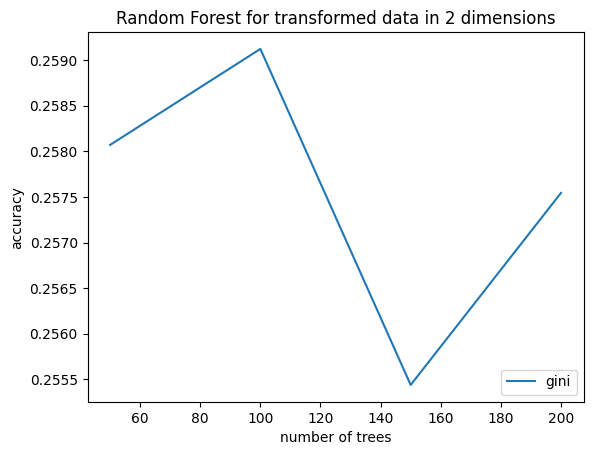

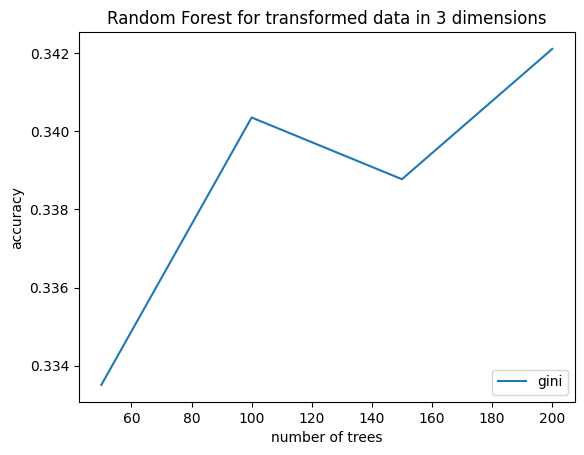

In [23]:
for elem in scores_rf: 
    for i, criterion in enumerate(elem):
        plt.plot(n_estimators, elem[i], label=criterions[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title(f"Random Forest for transformed data in {dims[scores_rf.index(elem)]} dimensions")
    plt.legend(loc="lower right")
    plt.show()

In [24]:
from sklearn.ensemble import BaggingClassifier

n_estimators = range(10, 110, 10)

scores_bagging = []

for i, pca_data in enumerate(X_pca):
    scores_bagging.append([])
    for n_estimator in n_estimators:
        bagging = BaggingClassifier(n_estimators=n_estimator)
        scores = cross_validate(bagging, pca_data, y)
        scores_bagging[i].append(np.mean(scores["test_score"]))

0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5


In [ ]:
for i, elem in enumerate(scores_bagging):
    plt.plot(n_estimators, elem, label=dims[i])
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.title("Bagging")
plt.legend(loc="upper right")
plt.show()

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

num_trees = range(20, 220, 20)

scores_et = []

for i, pca_data in enumerate(X_pca):
    scores_et.append([])
    for j, criterion in enumerate(criterions):
        scores_et[i].append([])
        for num_tree in num_trees:
            et = ExtraTreesClassifier(criterion=criterion,
                                    n_estimators=num_tree)
            scores = cross_validate(et, pca_data, y)
            scores_et[i][j].append(np.mean(scores["test_score"]))

In [ ]:
for elem in scores_et: 
    for i, criterion in enumerate(elem):
        plt.plot(num_trees, elem[i], label=criterions[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title(f"Extra Trees Classifier for transformed data in {dims[scores_et.index(elem)]} dimensions")
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

num_trees = range(20, 220, 20)

scores_ada = []

learning_rates = range(0.2, 2.2, 0.2)

for i, pca_data in enumerate(X_pca):
    scores_ada.append([])
    for j, lr in enumerate(learning_rates):
        scores_ada[i].append([])
        for num_tree in num_trees:
            ada = AdaBoostClassifier(learning_rate=lr,
                                    n_estimators=num_tree)
            scores = cross_validate(ada, pca_data, y)
            scores_ada[i][j].append(np.mean(scores["test_score"]))

In [ ]:
for elem in scores_ada: 
    for i, lr in enumerate(elem):
        plt.plot(num_trees, elem[i], label=lr[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title("Ada Boosting for transformed data in", dims[scores_ada.index(elem)],"dimensions")
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

num_trees = range(20, 220, 20)

scores_gb = []

for i, pca_data in enumerate(X_pca):
    scores_gb.append([])
    for num_tree in num_trees:
        gb = GradientBoostingClassifier(n_estimators=num_tree)
        scores = cross_validate(gb, pca_data, y)
        scores_gb[i][j].append(np.mean(scores["test_score"]))

In [ ]:
for i, elem in enumerate(scores_gb):
    plt.plot(n_estimators, elem, label=dims[i])
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.title("Gradient Boosting")
plt.legend(loc="upper right")
plt.show()

Ergebnisse:

Versuche im Kompressionsraum FFNN anzuwenden

In [ ]:
from tensorflow import keras
from keras import layers

In [ ]:
from sklearn.model_selection import train_test_split
from keras import to_categorical

X_trains = []
X_tests = []
y_trains = []
y_tests = []

y_categorical = to_categorical(y)

for dim in dims:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_categorical, test_size=0.2)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_train.append(y_train)
    y_test.append(y_test)

Visualisierung der Trainings-/Testfehler

In [ ]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [ ]:
for dim in dims:
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu", input_shape=(dim,)),
            layers.Dense(64, activation="relu"),
            layers.Dense(19, activation="softmax"),
        ]
    )

    # Modell kompilieren
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()])

    # Modell trainieren
    index = dims.index(dim)
    
    model.fit(X_train[index], y_train[index],
              validation_data=(X_test[index], y_test[index]), 
              epochs=100,
              batch_size=32,
              verbose=1,
              callbacks=[plot_losses])